In [1]:
import pandas as pd
import numpy as np
import math
import pickle
import os
import re
from Bio import Seq
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats
import matplotlib as mpl
import statsmodels.formula.api as smf
mpl.rcParams['pdf.fonttype'] = 42
import warnings
warnings.filterwarnings("ignore")


Bad key "text.kerning_factor" on line 4 in
/lustre/user/lulab/doushq/wuxk/software/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
with open("../Data/fly_rscu.pkl", "rb") as handle:
    RSCU_dict = pickle.load(handle)
    
RSCU_df = pd.DataFrame([RSCU_dict]).T.reset_index()
RSCU_df.columns = ['codon','rscu']
RSCU_df['category'] = ['optimal' if x >= 1 else 'nonoptimal' for x in RSCU_df['rscu']]
RSCU_df.head(2)

,codon,rscu,category
0,TGT,0.417587,nonoptimal
1,TGC,1.582413,optimal


In [3]:
samplenames = ['em02h','em1224h','larva','femalebody','malehead','em26h',
               'pupa','malebody','em612h','femalehead']

Text(0, 0.5, 'Density')

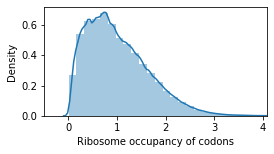

In [5]:
# take an example
plt.figure(figsize=(4,2))
samplename = samplenames[0]
Occ_tmp_df = pd.read_csv("../Data/RiboMrnaCoverageInfoTotal_codonFiltered_fly_"+samplename+"_ribo_1.csv.gz",sep="\t")
Occ_tmp_sample = pd.merge(Occ_tmp_df,RSCU_df,on='codon')
Occ_tmp_sample = Occ_tmp_sample[Occ_tmp_sample['norm_Asite'] > 0] # remove uncoveraged codons
sns.distplot(np.log2(Occ_tmp_sample['norm_Asite']+1))
plt.xlim(-0.5,4.1)
plt.xlabel("Ribosome occupancy of codons")
plt.ylabel("Density")

In [6]:
Occ_tmp_sample['log2norm_Asite'] = np.log2(Occ_tmp_sample['norm_Asite']+1)
Occ_tmp_sample.head(2)

,chr,geneid,trid,RPKM,protein,codon_loci,codon,mrna_depth,A_site_occ,CDS_length,empty_sites,empty_ratio,mean_Asite,norm_Asite,rscu,category,log2norm_Asite
2,chr2L,FBgn0000052,FBtr0079219,32.987841,A,77,GCC,2.459894,6.0,1355,425,0.313653,2.362069,2.540146,2.152484,optimal,1.823809
3,chr2L,FBgn0000052,FBtr0079219,32.987841,A,139,GCC,3.696510,1.0,1355,425,0.313653,2.362069,0.423358,2.152484,optimal,0.509298


In [7]:
stats.mannwhitneyu(Occ_tmp_sample[Occ_tmp_sample['category']=='optimal']['log2norm_Asite'],
                   Occ_tmp_sample[Occ_tmp_sample['category']=='nonoptimal']['log2norm_Asite'])

MannwhitneyuResult(statistic=630571892315.5, pvalue=1.0373204817968352e-38)

<Figure size 288x144 with 0 Axes>

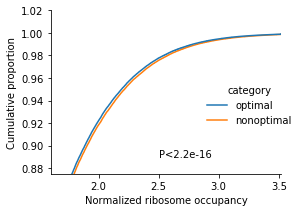

In [8]:
# ecdf plot
plt.figure(figsize=(4,2))
sns.displot(data=Occ_tmp_sample,x='log2norm_Asite',kind='ecdf',hue='category',height=3, aspect=1)
plt.xlabel("Normalized ribosome occupancy")
plt.ylabel("Cumulative proportion")
plt.ylim(0.875,1.02)
plt.xlim(1.6,3.52)
plt.text(2.5,0.890,'P<2.2e-16')
plt.tight_layout()

#### Compare the codon usage in the fast and slow region

In [9]:
# save result from multiple samples
Count_tmp = pd.DataFrame(columns = ['category','stall','nonstall','samplename','threshold'])
fast_tmp = pd.DataFrame(columns = ['category','fast','nonfast','samplename'])

for samplename in samplenames:
    Occ_tmp_df = pd.read_csv("../Data/RiboMrnaCoverageInfoTotal_codonFiltered_fly_"+samplename+"_ribo_1.csv.gz",sep="\t")
    ### retain the highest 1% as the candidates stalling sites
    Occ_tmp_sample = pd.merge(Occ_tmp_df,RSCU_df,on='codon')
    Occ_tmp_sample = Occ_tmp_sample[Occ_tmp_sample['norm_Asite'] >0] # remove zero sites
    threshold01 = np.quantile(Occ_tmp_sample['norm_Asite'],0.99)
    threshold01_bottom = np.quantile(Occ_tmp_sample['norm_Asite'],0.01)
    
    Occ_tmp_sample_stall = Occ_tmp_sample[Occ_tmp_sample['norm_Asite'] > threshold01]
    Occ_tmp_sample_nonstall = Occ_tmp_sample[Occ_tmp_sample['norm_Asite'] <= threshold01]
    Count_df = pd.DataFrame([Occ_tmp_sample_stall.groupby(['category'])['protein'].count(),Occ_tmp_sample_nonstall.groupby(['category'])['protein'].count()]).T
    Count_df.columns = ['stall','nonstall']
    Count_df.reset_index(inplace=True)
    Count_df['samplename'] = samplename
    Count_df['threshold'] = '0.001'
    Count_tmp = Count_tmp.append(Count_df)
    
    Occ_tmp_sample_fast = Occ_tmp_sample[Occ_tmp_sample['norm_Asite'] < threshold01_bottom]
    Occ_tmp_sample_nonfast = Occ_tmp_sample[Occ_tmp_sample['norm_Asite'] > threshold01_bottom]
    
    fast_df = pd.DataFrame([Occ_tmp_sample_fast.groupby(['category'])['protein'].count(),Occ_tmp_sample_nonfast.groupby(['category'])['protein'].count()]).T
    fast_df.columns = ['fast','nonfast']
    fast_df = fast_df.reset_index()
    fast_df['samplename'] = samplename
    fast_tmp = fast_tmp.append(fast_df)

In [10]:
result_df = pd.DataFrame(columns = ['samplename','RR','pvalue'])
for samplename in fast_tmp['samplename'].unique():
    fast_df = fast_tmp[fast_tmp['samplename'] == samplename]
    RR = (fast_df.iloc[0,1]/(fast_df.iloc[0,1]+fast_df.iloc[0,2]))/(fast_df.iloc[1,1]/(fast_df.iloc[1,1]+fast_df.iloc[1,2]))
    pvalue = stats.chi2_contingency([[fast_df.iloc[0,1],fast_df.iloc[0,2]],[fast_df.iloc[1,1],fast_df.iloc[1,2]]])[1]
#     print(RR,pvalue)
    tmp_df = pd.DataFrame([samplename,RR,pvalue]).T
    tmp_df.columns = ['samplename','RR','pvalue']
    result_df = result_df.append(tmp_df)

# sort by samples
sampleList = ['em02h','em26h','em612h','em1224h','larva','pupa','malebody','femalebody','malehead','femalehead']
result_df['samplename'] = result_df['samplename'].astype("category").cat.set_categories(sampleList)
result_df.sort_values("samplename",inplace=True)

In [11]:
slow_df = Count_tmp.copy()
slow_df.columns = ['category','slow','non_slow','samplename','threshold']

result_df = pd.DataFrame(columns = ['samplename','Enrichment','pvalue'])
for samplename in slow_df['samplename'].unique():
    slow_tmp = slow_df[slow_df['samplename'] == samplename]
    slow_tmp.sort_values("category",inplace=True)
    Enrich_nonoptimal = (slow_tmp.iloc[0,1]/(slow_tmp.iloc[0,1]+slow_tmp.iloc[1,1]))/(slow_tmp.iloc[0,2]/(slow_tmp.iloc[0,2]+slow_tmp.iloc[1,2]))
    pvalue = stats.chi2_contingency([[slow_tmp.iloc[0,1],slow_tmp.iloc[0,2]],[slow_tmp.iloc[1,1],slow_tmp.iloc[1,2]]])[1]
    
    tmp_df = pd.DataFrame([samplename,Enrich_nonoptimal,pvalue]).T
    tmp_df.columns = ['samplename','Enrichment','pvalue']
    result_df = result_df.append(tmp_df)
    
result_slow = result_df.copy()

In [12]:
fast_df = fast_tmp.copy()
fast_df.columns = ['category','fast','non_fast','samplename']

result_df = pd.DataFrame(columns = ['samplename','Enrichment','pvalue'])
for samplename in fast_df['samplename'].unique():
    fast_tmp = fast_df[fast_df['samplename'] == samplename]
    fast_tmp.sort_values("category",inplace=True)
    Enrich_optimal = (fast_tmp.iloc[1,1]/(fast_tmp.iloc[0,1]+fast_tmp.iloc[1,1]))/(fast_tmp.iloc[1,2]/(fast_tmp.iloc[0,2]+fast_tmp.iloc[1,2]))
    pvalue = stats.chi2_contingency([[fast_tmp.iloc[0,1],fast_tmp.iloc[0,2]],[fast_tmp.iloc[1,1],fast_tmp.iloc[1,2]]])[1]
    
    tmp_df = pd.DataFrame([samplename,Enrich_optimal,pvalue]).T
    tmp_df.columns = ['samplename','Enrichment','pvalue']
    result_df = result_df.append(tmp_df)

result_fast = result_df.copy()

In [13]:
# sort by samples
sampleList = ['em02h','em26h','em612h','em1224h','larva','pupa','malebody','femalebody','malehead','femalehead']
result_fast['samplename'] = result_fast['samplename'].astype("category").cat.set_categories(sampleList)
result_fast.sort_values("samplename",inplace=True)

result_slow['samplename'] = result_slow['samplename'].astype("category").cat.set_categories(sampleList)
result_slow.sort_values("samplename",inplace=True)

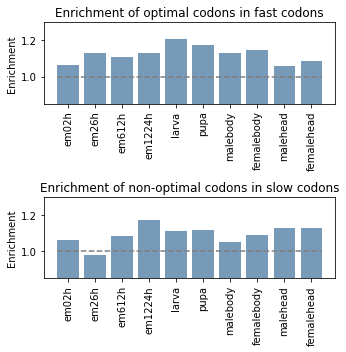

In [14]:
plt.figure(figsize=(5,5))

plt.subplot(2,1,1)
sns.barplot(x='samplename',y='Enrichment',data=result_fast,color='steelblue',alpha=0.8)
plt.title("Enrichment of optimal codons in fast codons")
plt.xticks(rotation=90)
plt.ylim(0.85,1.30)
plt.hlines(1,-0.4,9.4,color='gray',linestyles='dashed')
plt.xlabel("")

plt.subplot(2,1,2)
sns.barplot(x='samplename',y='Enrichment',data=result_slow,color='steelblue',alpha=0.8)
plt.title("Enrichment of non-optimal codons in slow codons")
plt.xticks(rotation=90)
plt.ylim(0.85,1.30)
plt.hlines(1,-0.4,9.4,color='gray',linestyles='dashed')
plt.xlabel("")

plt.tight_layout()